In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


# Libraries used in project

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier


# Data Reading

In [5]:
df = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
df_test = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
df_movie = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv")

In [6]:
train = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
movies = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')
df_test = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")

movies = movies.drop_duplicates(subset = 'movieid')
merge = pd.merge(train, movies, on = 'movieid', how = 'left')
merge_test = pd.merge(df_test, movies, on = "movieid", how ="left")

In [7]:
merge_test.rename(columns={'isTopCritic':'isFrequentReviewer'}, inplace = True)

In [8]:
merge_test.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...,Legend Marty McFly Oracle,57.0,R,"['Gore', 'Bloody Horror Violence', 'Language T...",2022-10-14,2022-10-14,111.0,"Holiday, Horror, Mystery & thriller",English,Sara Barnett,$64.0M,Universal Pictures,Dolby Atmos
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...,Terminator Katniss Everdeen Glimmer,86.0,PG,['Emotional Thematic Material'],2002-11-29,2003-04-15,94.0,"Drama, Adventure",English,Cindy Flander,$6.2M,Miramax Films,"Dolby SR, DTS, Dolby Stereo, Surround, SDDS, D..."
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...,James Bond Labyrinth Gollum,62.0,NaN,NaN,NaN,NaN,NaN,Drama,French,Charlotte Bramble,NaN,NaN,NaN
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...,V Quest Han Solo Wondrous,84.0,NaN,NaN,2021-07-16,2021-08-03,92.0,"Drama, Mystery & thriller",English,Jean Gainer,$3.1M,Neon,NaN
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...,Enigma Hulk Surreal Starlight,NaN,NaN,NaN,NaN,NaN,66.0,"Drama, Musical",Arabic,Marvin Short,NaN,NaN,NaN


In [9]:



new_train = merge[["reviewText", "audienceScore", "runtimeMinutes","genre", "sentiment",'rating','ratingContents','distributor','director','originalLanguage','soundType','boxOffice','reviewerName','movieid','title','isFrequentReviewer','releaseDateStreaming']]
new_test = merge_test[["reviewText", "audienceScore", "runtimeMinutes","genre",'rating','ratingContents','distributor','director','originalLanguage','soundType','boxOffice','reviewerName','movieid','title','isFrequentReviewer','releaseDateStreaming']]
y= new_train['sentiment']




In [10]:
new_train.isna().sum()

reviewText               6447
audienceScore           13248
runtimeMinutes           3376
genre                    2438
sentiment                   0
rating                  63724
ratingContents          63724
distributor             40663
director                    0
originalLanguage         3290
soundType               85367
boxOffice               52776
reviewerName                0
movieid                     0
title                       0
isFrequentReviewer          0
releaseDateStreaming    16185
dtype: int64

In [11]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162758 entries, 0 to 162757
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   reviewText            156311 non-null  object 
 1   audienceScore         149510 non-null  float64
 2   runtimeMinutes        159382 non-null  float64
 3   genre                 160320 non-null  object 
 4   sentiment             162758 non-null  object 
 5   rating                99034 non-null   object 
 6   ratingContents        99034 non-null   object 
 7   distributor           122095 non-null  object 
 8   director              162758 non-null  object 
 9   originalLanguage      159468 non-null  object 
 10  soundType             77391 non-null   object 
 11  boxOffice             109982 non-null  object 
 12  reviewerName          162758 non-null  object 
 13  movieid               162758 non-null  object 
 14  title                 162758 non-null  object 
 15  

In [12]:
new_train.describe()

,audienceScore,runtimeMinutes
count,149510.000000,159382.000000
mean,65.214541,106.911828
std,19.937695,22.138131
min,0.000000,4.000000
25%,51.000000,93.000000
50%,68.000000,104.000000
75%,82.000000,118.000000
max,100.000000,561.000000


### Ploting Sentiment Column

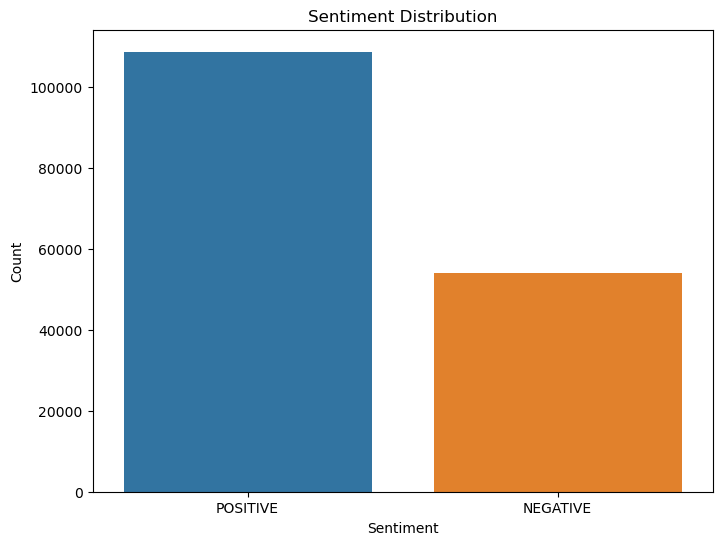

In [13]:
sentiment_counts = new_train['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')

plt.show()


### heatmap of missing values

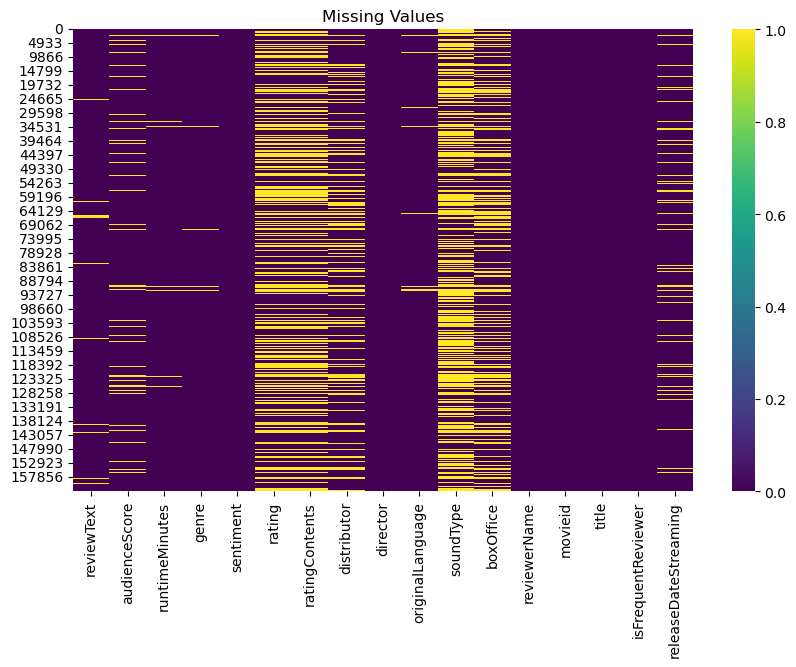

In [14]:
plt.figure(figsize=(10,6))
sns.heatmap(new_train.isna(), cmap = 'viridis')
plt.title("Missing Values")
plt.show()

### Observations : 

        - reviewText have null values
        - Other features does not have any null values


### Bar plot for isFrequentReviewer

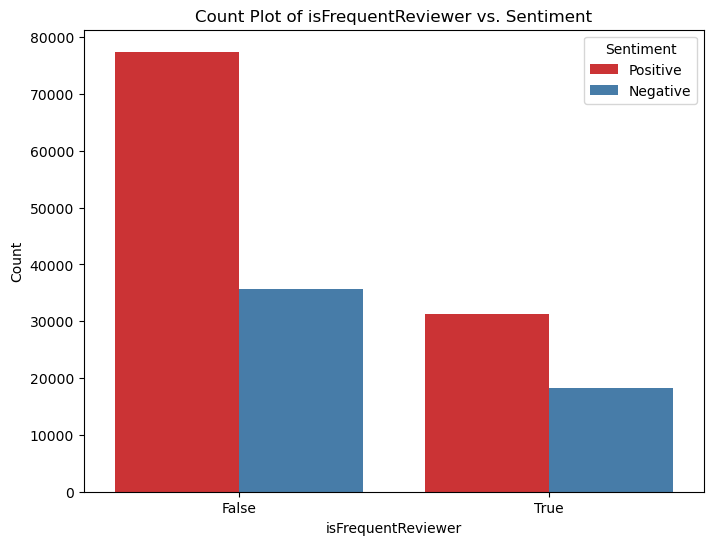

In [15]:

# Bar plot for isFrequentReviewer


plt.figure(figsize=(8, 6))
sns.countplot(x='isFrequentReviewer', hue='sentiment', data=new_train, palette='Set1')
plt.title('Count Plot of isFrequentReviewer vs. Sentiment')
plt.xlabel('isFrequentReviewer')
plt.ylabel('Count')
plt.legend(title='Sentiment', loc='upper right', labels=['Positive','Negative'])
plt.show()




### Distribution of Audience Score by Sentiment

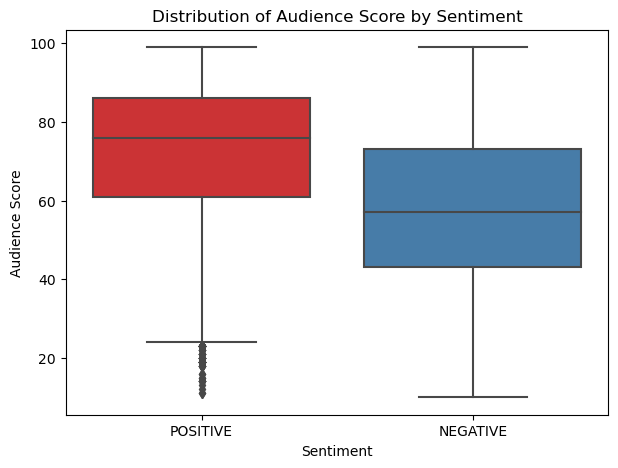

In [16]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='sentiment', y='audienceScore', data=new_train.dropna(), palette='Set1')
plt.title('Distribution of Audience Score by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Audience Score')
plt.show()

### Observations

     - When Audience Score is below 40 or above 72 is then sentiment is 'POSITIVE'

Text(0.5, 1.0, 'KDE of Audience Score')

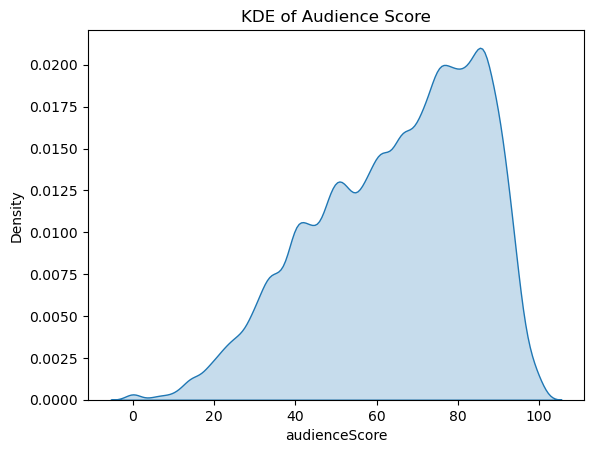

In [17]:
sns.kdeplot(data = new_train['audienceScore'], fill =True)
plt.title("KDE of Audience Score")

# Data Preprocessing

In [18]:
new_train['audienceScore'].skew()
new_train['runtimeMinutes'].skew()


1.8192701265556988

In [19]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy = 'median' , missing_values= np.nan)

new_train['audienceScore'] = imp.fit_transform(new_train[['audienceScore']])
new_test['audienceScore'] = imp.fit_transform(new_test[['audienceScore']])







/tmp/ipykernel_33/743593992.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_train['audienceScore'] = imp.fit_transform(new_train[['audienceScore']])
/tmp/ipykernel_33/743593992.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_test['audienceScore'] = imp.fit_transform(new_test[['audienceScore']])


In [20]:
imp2 = SimpleImputer(strategy = 'mean' , missing_values= np.nan)
new_train['runtimeMinutes'] = imp.fit_transform(new_train[['runtimeMinutes']])
new_test['runtimeMinutes'] = imp.fit_transform(new_test[['runtimeMinutes']])


/tmp/ipykernel_33/465612470.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_train['runtimeMinutes'] = imp.fit_transform(new_train[['runtimeMinutes']])
/tmp/ipykernel_33/465612470.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_test['runtimeMinutes'] = imp.fit_transform(new_test[['runtimeMinutes']])


In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

scler = StandardScaler()

new_train['audienceScore'] = scler.fit_transform(new_train[['audienceScore']])
new_test['audienceScore'] = scler.fit_transform(new_test[['audienceScore']])
new_train['runtimeMinutes'] = scler.fit_transform(new_train[['runtimeMinutes']])

new_test['runtimeMinutes'] = scler.fit_transform(new_test[['runtimeMinutes']])




/tmp/ipykernel_33/2571944721.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_train['audienceScore'] = scler.fit_transform(new_train[['audienceScore']])
/tmp/ipykernel_33/2571944721.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_test['audienceScore'] = scler.fit_transform(new_test[['audienceScore']])
/tmp/ipykernel_33/2571944721.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [22]:
new_train['boxOffice'] = new_train['boxOffice'].str.replace('$', "")
new_train['boxOffice'] = new_train['boxOffice'].str.replace('M', '000000')
new_train['boxOffice'] = new_train['boxOffice'].str.replace('K', '000')
new_train['boxOffice'] = new_train['boxOffice'].astype(float)

mm =new_train['boxOffice'].median()
new_train['boxOffice'] = new_train['boxOffice'].fillna(value = mm)


new_test['boxOffice'] = new_test['boxOffice'].str.replace('$', "")
new_test['boxOffice'] = new_test['boxOffice'].str.replace('M', '000000')
new_test['boxOffice'] = new_test['boxOffice'].str.replace('K', '000')
new_test['boxOffice'] = new_test['boxOffice'].astype(float)

nn =new_test['boxOffice'].median()
new_test['boxOffice'] = new_test['boxOffice'].fillna(value = nn)



/tmp/ipykernel_33/3007798956.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  new_train['boxOffice'] = new_train['boxOffice'].str.replace('$', "")
/tmp/ipykernel_33/3007798956.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_train['boxOffice'] = new_train['boxOffice'].str.replace('$', "")
/tmp/ipykernel_33/3007798956.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [23]:
new_train['releaseDateStreaming'].dtype

new_train['releaseDateStreaming'] = pd.to_datetime(new_train['releaseDateStreaming'])
new_test['releaseDateStreaming'] = pd.to_datetime(new_test['releaseDateStreaming'])

new_train['day'] = new_train['releaseDateStreaming'].dt.day
new_train['month'] =  new_train['releaseDateStreaming'].dt.month
new_train['year'] =  new_train['releaseDateStreaming'].dt.year

new_test['day'] = new_test['releaseDateStreaming'].dt.day
new_test['month'] =  new_test['releaseDateStreaming'].dt.month
new_test['year'] =  new_test['releaseDateStreaming'].dt.year

new_train['day'] = imp.fit_transform(new_train[['day']])
new_test['day'] = imp.fit_transform(new_test[['day']])

new_train['month'] = imp.fit_transform(new_train[['month']])
new_test['month'] = imp.fit_transform(new_test[['month']])

new_train['year'] = imp.fit_transform(new_train[['year']])
new_test['year'] = imp.fit_transform(new_test[['year']])

/tmp/ipykernel_33/274932487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_train['releaseDateStreaming'] = pd.to_datetime(new_train['releaseDateStreaming'])
/tmp/ipykernel_33/274932487.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_test['releaseDateStreaming'] = pd.to_datetime(new_test['releaseDateStreaming'])


### Dummy Model

In [24]:
# model 1 : Dummy Model
""" 
model = DummyClassifier(strategy = 'most_frequent')
model.fit(X,y) 
model.score(X,y)4
"""


" \nmodel = DummyClassifier(strategy = 'most_frequent')\nmodel.fit(X,y) \nmodel.score(X,y)4\n"

#### Score of dummy model : 0.6699400554023709

# Text Prerocessing

#### Text Processing conclusions:

        1] Two good vectorizers : 1. CountVectorizer  2. TfidfVectorizer
        2] TfidfVectorizer perform better than CountVectorizer in most of the models
        3] TfidfVectorizer is good with parameter as ngram_range = (1,2) for most of the models
           but, LinearSVC is perform better with n_gram_range = (1,3)

In [25]:
'''
vectorizer = TfidfVectorizer(ngram_range = (1,4))
X_train = vectorizer.fit_transform(df['reviewText'])
y_train = df['sentiment']
'''

"\nvectorizer = TfidfVectorizer(ngram_range = (1,4))\nX_train = vectorizer.fit_transform(df['reviewText'])\ny_train = df['sentiment']\n"

In [26]:
""" 
sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=True, stop_words='english')
text_matrix = vectorizer.fit_transform(df['reviewText'])
"""

" \nsklearn.feature_extraction.text import CountVectorizer\nvectorizer = CountVectorizer(lowercase=True, stop_words='english')\ntext_matrix = vectorizer.fit_transform(df['reviewText'])\n"

In [27]:
new_train.isna().sum()

reviewText               6447
audienceScore               0
runtimeMinutes              0
genre                    2438
sentiment                   0
rating                  63724
ratingContents          63724
distributor             40663
director                    0
originalLanguage         3290
soundType               85367
boxOffice                   0
reviewerName                0
movieid                     0
title                       0
isFrequentReviewer          0
releaseDateStreaming    16185
day                         0
month                       0
year                        0
dtype: int64

In [28]:
text_columns = ['reviewText', 'genre','rating', 'ratingContents','distributor' ,'director', 'originalLanguage', 'soundType','reviewerName','movieid','title','isFrequentReviewer']
for column in text_columns:
    new_train[column] = new_train[column].fillna(value='')
    new_test[column] = new_test[column].fillna(value='')
from sklearn.feature_extraction.text import TfidfVectorizer

vector = TfidfVectorizer(stop_words = 'english',ngram_range = (1,2))

train_vector = vector.fit_transform(new_train['reviewText'] + ' ' + new_train['genre'] + ' ' + new_train['ratingContents'] + ' ' + new_train['director'] + ' ' + new_train['originalLanguage'] + ' ' + new_train['soundType']+ ' ' + new_train['reviewerName']+ ' ' + new_train['movieid']+ ' ' + new_train['title']+ ' ' + new_train['isFrequentReviewer'].astype(str))
test_vector = vector.transform(new_test['reviewText'] + ' ' + new_test['genre'] + ' ' + new_test['ratingContents'] + ' ' + new_test['director'] + ' ' + new_test['originalLanguage'] + ' ' + new_test['soundType']+ ' ' + new_test['reviewerName']+ ' ' + new_test['movieid']+ ' ' + new_test['isFrequentReviewer'].astype(str))

new_train.drop(columns= ['reviewText', 'sentiment', 'genre','rating', 'ratingContents','distributor' ,'director', 'originalLanguage', 'soundType','reviewerName','movieid','title','boxOffice','isFrequentReviewer','releaseDateStreaming','day','month','year'], inplace=True)
new_test.drop(columns=['reviewText', 'genre','rating', 'ratingContents','distributor' ,'director', 'originalLanguage', 'soundType','reviewerName','movieid','title','boxOffice','isFrequentReviewer','releaseDateStreaming','day','month','year'], inplace=True)

from scipy.sparse import hstack,csr_matrix 
X = hstack([train_vector, csr_matrix(new_train)])
X_test = hstack([test_vector, csr_matrix(new_test)])



from sklearn.model_selection import train_test_split

X_trai, X_tes, y_trai, y_tes = train_test_split(X,y, test_size = 0.2)

# Models and Classification Report

### Models Conclusion :
             
*                         best score is     0.81267      
*                       LinearSVC is best model so far, without hyperparameters
*                       2nd best model is Logistic regression with Hyperparameter Tunning
*                       3rd best Model is RidgeClassifier
*                       Another Observation is training model with whole dataset without spliting increase the accuracy, for this case

In [379]:
from sklearn.svm import LinearSVC

model = LinearSVC(C = 1, max_iter = 200)
model.fit(X_trai, y_trai)
y_pred = model.predict(X_tes)
from sklearn.metrics import classification_report, f1_score
print(classification_report(y_tes, y_pred))


pred = model.predict(X_test)
print(f1_score(y_tes,y_pred,pos_label = "POSITIVE"))

pd.DataFrame(pred).value_counts()

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

    NEGATIVE       0.78      0.66      0.72     10786
    POSITIVE       0.84      0.91      0.87     21766

    accuracy                           0.83     32552
   macro avg       0.81      0.79      0.80     32552
weighted avg       0.82      0.83      0.82     32552

0.8744540758640565


POSITIVE    38350
NEGATIVE    16965
dtype: int64

In [395]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score

linear_svc = LinearSVC()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 200, 300, 400, 500]
}

grid_search = GridSearchCV(linear_svc, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

grid_search.fit(X_trai, y_trai)

print("Best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_tes)
print("Classification Report:")
print(classification_report(y_tes, y_pred))
# F1 score on the test set
f1 = f1_score(y_tes, y_pred, pos_label="POSITIVE")
print("F1 Score:", f1)

pred_counts = pd.Series(y_pred).value_counts()
print("Predicted Class Counts:")
print(pred_counts)
# Best parameters: {'C': 1, 'max_iter': 400}


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Best parameters: {'C': 1, 'max_iter': 400}
Classification Report:
              precision    recall  f1-score   support

    NEGATIVE       0.78      0.66      0.72     10786
    POSITIVE       0.84      0.91      0.87     21766

    accuracy                           0.83     32552
   macro avg       0.81      0.79      0.80     32552
weighted avg       0.82      0.83      0.82     32552



NameError: name 'y_test' is not defined

[CV] END ..............................C=0.001, max_iter=100; total time=   3.1s
[CV] END ..............................C=0.001, max_iter=200; total time=   3.5s
[CV] END ..............................C=0.001, max_iter=300; total time=   2.9s
[CV] END ..............................C=0.001, max_iter=400; total time=   2.9s
[CV] END ..............................C=0.001, max_iter=400; total time=   2.7s
[CV] END ..............................C=0.001, max_iter=500; total time=   3.0s
[CV] END ...............................C=0.01, max_iter=100; total time=  11.8s
[CV] END ...............................C=0.01, max_iter=100; total time=  13.8s
[CV] END ...............................C=0.01, max_iter=300; total time=  12.2s
[CV] END ...............................C=0.01, max_iter=300; total time=  11.8s
[CV] END ...............................C=0.01, max_iter=400; total time=  12.7s
[CV] END ...............................C=0.01, max_iter=500; total time=  11.6s
[CV] END ...................

In [29]:
from sklearn.svm import LinearSVC 

model = LinearSVC(C = 1, max_iter = 400)
model.fit(X, y)
y_pred = model.predict(X_tes)
from sklearn.metrics import classification_report, f1_score
print(classification_report(y_tes, y_pred))


pred = model.predict(X_test)
print(f1_score(y_tes,y_pred,pos_label = "POSITIVE"))

pd.DataFrame(pred).value_counts()

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

    NEGATIVE       0.99      0.99      0.99     10782
    POSITIVE       0.99      1.00      1.00     21770

    accuracy                           0.99     32552
   macro avg       0.99      0.99      0.99     32552
weighted avg       0.99      0.99      0.99     32552

0.9958953427044877


POSITIVE    38087
NEGATIVE    17228
dtype: int64

In [30]:
f1 = f1_score(y_tes, y_pred, pos_label="POSITIVE")
print("F1 Score:", f1)

# Optional: Get the counts of predicted classes
pred_counts = pd.Series(y_pred).value_counts()
print("Predicted Class Counts:")
print(pred_counts)
print("Best parameters:", random_search.best_params_)


F1 Score: 0.9958953427044877
Predicted Class Counts:
POSITIVE    21839
NEGATIVE    10713
dtype: int64


NameError: name 'random_search' is not defined

In [ ]:
from scipy.stats import loguniform

logreg = LogisticRegression()

param_dist = {
    'C': loguniform(0.001, 1000),  # Regularization parameter
    'max_iter': [100, 200, 300, 400, 500]
}

random_search = RandomizedSearchCV(logreg, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, n_jobs=-1, random_state=42)

random_search.fit(X_trai, y_trai)

print("Best parameters:", random_search.best_params_)

best_model = random_search.best_estimator_


y_pred = best_model.predict(X_tes)
print("Classification Report:")
print(classification_report(y_tes, y_pred))

f1 = f1_score(y_tes, y_pred, pos_label="POSITIVE")
print("F1 Score:", f1)

pred_counts = pd.Series(y_pred).value_counts()
print("Predicted Class Counts:")
print(pred_counts)
#  {'C': 18.77688470273464, 'max_iter': 500}

In [392]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C = 18.77, max_iter = 500)
model.fit(X, y)
y_pred = model.predict(X_tes)
from sklearn.metrics import classification_report, f1_score
print(classification_report(y_tes, y_pred))


pred = model.predict(X_test)
print(f1_score(y_tes,y_pred,pos_label = "POSITIVE"))

pd.DataFrame(pred).value_counts()

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00     10786
    POSITIVE       1.00      1.00      1.00     21766

    accuracy                           1.00     32552
   macro avg       1.00      1.00      1.00     32552
weighted avg       1.00      1.00      1.00     32552

0.998208626154058


POSITIVE    37997
NEGATIVE    17318
dtype: int64

### Model 2 : Logistic Regression

In [ ]:
 """
model = LogisticRegression()
model.fit(X_tr, y_tr)

pred = model.predict(X_t)

accuracy = accuracy_score(y_t, pred)
print("Accuracy:", accuracy)
"""

In [ ]:
# X = df['reviewText']
# y = df['sentiment']
# X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.3, random_state = 0)

# """ 

# pipe = Pipeline([
#     ('tfidf', TfidfVectorizer()),  
#     ('model', LogisticRegression())  
# ])

# param_dist = {
#     'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  
#     'tfidf__use_idf': [True, False],  
#     'model__C': uniform(0.1, 1.0),  
#     'model__max_iter': [100, 200, 500],  
# }

# random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=-1, verbose=1)
# random_search.fit(X_train, y_train)

# best_params = random_search.best_params_
# best_model = random_search.best_estimator_
# """
# pipe = Pipeline([
#     ('tfidf', TfidfVectorizer(ngram_range = (1,2,), use_idf = True)), 
#     ('model', LogisticRegression(C =  0.9555908857944696, max_iter= 200)) 
# ])

# pipe.fit(X_train, y_train)

# y_pred = pipe.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# pred = pipe.predict(X_test)

# print(classification_report(y_test,pred))
# print(confusion_matrix(y_test, pred))
# print(f1_score(pred, y_test,pos_label='POSITIVE'))

(1, 2)      Best Parameters: {'model__C': 0.9555908857944696, 'model__max_iter': 200, 'tfidf__ngram_range': (1, 2), 'tfidf__use_idf': True}
     
     Accuracy: 0.798271483574998
        
        precision    recall  f1-score   support

    NEGATIVE       0.79      0.53      0.64     16198
    POSITIVE       0.80      0.93      0.86     32630

    accuracy                           0.80     48828
      macro avg       0.80      0.73      0.75     48828
    weighted avg       0.80      0.80      0.79     48828

        [[ 8612  7586]
      [ 2264 30366]]
     
     0.8604460060638689

In [ ]:
"""
print(classification_report(y_t,pred))
print(confusion_matrix(y_t, pred))
print(f1_score(pred, y_t,pos_label='POSITIVE'))
"""

    
                 precision    recall  f1-score   support

    NEGATIVE       0.80      0.44      0.57     16198
    POSITIVE       0.77      0.94      0.85     32630

    accuracy                           0.78     48828
    macro avg        0.79      0.69      0.71     48828
   
    weighted avg       0.78      0.78      0.76     48828

confusion_matrix:

    [[ 7171  9027]
     [ 1813 30817]]
     
F1 score:     0.8504291194083395

In [ ]:
""" 

pipe = Pipeline([('tfidf',TfidfVectorizer(lowercase=True, stop_words='english',ngram_range = (1,3))) ,('model2', LogisticRegression())])
pipe.fit(X_tr, y_tr)

"""

#### Accuracy : 0.7858574657738729


### Hyperparameter Tuning on Logistic Regression

In [ ]:

# param_dist = {
#     'C': np.logspace(-4, 4, 10),
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear', 'saga'],
#     'max_iter': [100, 200, 500],
#     'tol': [1e-3, 1e-4, 1e-5],
#     'class_weight': [None, 'balanced']
# }

# model = LogisticRegression(max_iter=1000)
# random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
# random_search.fit(X_tr, y_tr)
# best_params = random_search.best_params_
# best_model = random_search.best_estimator_


# #best_model = LogisticRegression(tol= 0.001,solver= 'saga', penalty= 'l2',max_iter= 200,class_weight= None,C= 21.54434690031882)



In [ ]:
""" 
Time to run : 20 min.

best_params 
{'tol': 0.001,
 'solver': 'saga',
 'penalty': 'l2',
 'max_iter': 200,
 'class_weight': None,
 'C': 21.54434690031882}
"""

In [ ]:
"""
best_model.fit(X_tr, y_tr)

pred = best_model.predict(X_t)

accuracy = accuracy_score(y_t, pred)
print("Accuracy:", accuracy)
"""

### Accuracy: 0.7973089211108381


In [ ]:
"""
print(classification_report(y_t,pred))
print(confusion_matrix(y_t, pred))
print(f1_score(pred, y_t,pos_label='POSITIVE'))
"""

              precision    recall  f1-score   support

    NEGATIVE       0.76      0.56      0.65     16198
    POSITIVE       0.81      0.91      0.86     32630

    accuracy                           0.80     48828
    
       macro avg       0.79      0.74      0.75     48828
    weighted avg       0.79      0.80      0.79     48828


Confusion Matrix :
                     
                     [[ 9128  7070]
                    
                    [ 2827 29803]]

F1 score:     0.8576032689236437

In [ ]:
""" 
param_grid = {
    'C': np.logspace(-3, 3, 7),     
    'max_iter': [100, 500, 1000],    
    'solver': ['saga', 'lbfgs']    
}

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_

Best Hyperparameters: {'solver': 'lbfgs', 'max_iter': 500, 'C': 1000.0}

model = LogisticRegression(solver= 'lbfgs', max_iter= 500, C= 1000.0)

"""

In [ ]:
""" 
time needed : 2 hours
Best Hyperparameters: {'solver': 'lbfgs', 'max_iter': 500, 'C': 1000.0}
(C=100,max_iter=1000,solver='saga')
"""

In [ ]:
 """
model = LogisticRegression(C=100,max_iter=1000,solver='saga')
model.fit(X_tr, y_tr)

pred = model.predict(X_t)

accuracy = accuracy_score(y_t, pred)
print("Accuracy:", accuracy)
"""

#### Accuracy: 0.7951994757106579


In [ ]:
"""
print(classification_report(y_t,pred))
print(confusion_matrix(y_t, pred))
print(f1_score(pred, y_t,pos_label='POSITIVE'))
"""

              precision    recall  f1-score   support

    NEGATIVE       0.75      0.57      0.65     16198
    POSITIVE       0.81      0.91      0.86     32630

    accuracy                           0.80     48828
    macro avg       0.78      0.74      0.75     48828
    weighted avg       0.79      0.80      0.79     48828
    
    
    CONFUSION MATRIX:
    [[ 9253  6945]
    [ 3055 29575]]
    
    F1 SCORE:0.8553868402024584
    


### Model 3: LinearSVC

In [ ]:
"""
model = LinearSVC()
model.fit(X_tr, y_tr)
pred = model.predict(X_t)

print(classification_report(y_t,pred))
print(confusion_matrix(y_t, pred))
print(f1_score(pred, y_t,pos_label='POSITIVE'))
"""

            precision    recall  f1-score   support

    NEGATIVE       0.76      0.56      0.65     16198
    POSITIVE       0.81      0.91      0.86     32630

    accuracy                           0.80     48828
    macro avg       0.79      0.74      0.75     48828
    weighted avg       0.79      0.80      0.79     48828

    Confusion Matrix: 
     [[ 9042  7156]
     [ 2779 29851]]
     
     F1 score : 0.8573315909645736

In [ ]:
"""
model = LinearSVC()
param_dist = {
    'C': np.logspace(-3, 3, 10),
    'penalty': ['l2'],
    'loss': ['squared_hinge'],
    'dual': [True, False],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced'],
    'intercept_scaling': [1.0, 2.0, 3.0],
    'max_iter': [1000, 2000, 3000]
}
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='f1_macro', random_state=42)



random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_model = random_search.best_estimator_
"""

In [ ]:
# best hyperparameters : 
""" {'penalty': 'l2',
 'max_iter': 2000,
 'loss': 'squared_hinge',
 'intercept_scaling': 1.0,
 'fit_intercept': True,
 'dual': True,
 'class_weight': 'balanced',
 'C': 46.41588833612773}


model = LinearSVC(penalty= 'l2',
 max_iter= 2000,
 loss= 'squared_hinge',
 intercept_scaling= 1.0,
 fit_intercept= True,
 dual= True,
 class_weight= 'balanced',
 C= 46.41588833612773)
model.fit(X_tr, y_tr)




pred = model.predict(X_t)
from sklearn.metrics import f1_score, classification_report, confusion_matrix

print(classification_report(y_t,pred))
print(confusion_matrix(y_t, pred))
print(f1_score(pred, y_t,pos_label='POSITIVE'))
"""

         precision    recall  f1-score   support

    NEGATIVE       0.68      0.65      0.66     16198
    POSITIVE       0.83      0.85      0.84     32630

    accuracy                           0.78     48828
     macro avg       0.75      0.75      0.75     48828
    weighted avg       0.78      0.78      0.78     48828
    
    Confusion Matrix:

     [[10483  5715]
     [ 4958 27672]]
     
     F1 score :  0.8383295211839374


### Model 4: RidgeClassifier

In [ ]:
""" 
param_distributions = {
    'alpha': uniform(loc=0, scale=10),  
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}
model13 = RidgeClassifier()
random_search = RandomizedSearchCV(estimator=model13, 
                                    param_distributions=param_distributions,
                                    cv=5, 
                                    n_iter=10)

random_search.fit(X_tr, y_tr)
best_params = random_search.best_params_
 
#best_params: {'alpha': 3.096149524540197, 'solver': 'auto'}


best_model = RidgeClassifier(alpha = 3.096149524540197, solver = 'auto')
best_model.fit(X_tr, y_tr)
best_model.score(X_tr, y_tr)


# score = 0.8725405509165947
# f1 score actual = 0.779
# f1 score with hpt = 0.78673
"""

In [ ]:
""" 
pred = best_model.predict(X_t)

print(classification_report(y_t,pred))
print(confusion_matrix(y_t, pred))
print(f1_score(pred, y_t,pos_label='POSITIVE'))
"""


              precision    recall  f1-score   support

    NEGATIVE       0.80      0.47      0.59     16198
    POSITIVE       0.78      0.94      0.85     32630

    accuracy                           0.78     48828
     macro avg       0.79      0.70      0.72     48828
    weighted avg       0.79      0.78      0.77     48828
    
    Confusion Matrix

    [[ 7556  8642]
    [ 1858 30772]]
    
    F! score:  0.8542557326078507

### Model 4 : MultinomialNB

In [ ]:

""" 
X = df['reviewText']
y = df['sentiment']
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.3, random_state = 0)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Define the hyperparameters and their distributions to search through
param_dist = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': [True, False],
    'nb__alpha': uniform(0.1, 1.0)
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=-1, verbose=1)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Evaluate the best model on your test data
accuracy = best_model.score(X_test, y_test)
print("Best hyperparameters:", best_params)
print("Accuracy on test data:", accuracy)
pred = best_model.predict(X_test)

print(classification_report(y_test,pred))
print(confusion_matrix(y_test, pred))
print(f1_score(pred, y_test,pos_label='POSITIVE'))
"""

         Best hyperparameters: {'nb__alpha': 0.2840066034002151,            'tfidf__ngram_range': (1, 1), 'tfidf__use_idf': False}
         
      Accuracy on test data: 0.7489759973785532

         
                    precision    recall  f1-score   support

    NEGATIVE       0.88      0.28      0.43     16198
    POSITIVE       0.73      0.98      0.84     32630

    accuracy                           0.75     48828
     macro avg       0.80      0.63      0.63     48828
    weighted avg       0.78      0.75      0.70     48828

    Confusion Matrix
    [[ 4592 11606]
     [  651 31979]]
     
     F1 score   0.8391786393754511

### Model 5: AdaBoostClassifier 

In [ ]:

""" 
model10 = AdaBoostClassifier()
model10.fit(X_train, y_train)
model10.score(X_train, y_train)

# score= 0.6659136045833426

#After submission
# F1 Score : 0.70346 V18

"""

### Model 6 : XGBClassifier

In [ ]:
""" 
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
model9 = XGBClassifier()
model9.fit(X_train, y_train_encoded)
model9.score(X_train, y_train_encoded)
# score = 0.771617984983841
"""

### Model 11 : DecisionTreeClassifier

In [ ]:
'''
from sklearn.tree import DecisionTreeClassifier

model4 = DecisionTreeClassifier()+
model4.fit(X_train, y_train)
#0.9847319332997456
'''

### Model 12 : ExtraTreesClassifier

In [ ]:
"""

model12 = ExtraTreesClassifier()
model12.fit(X_train, y_train)
model12.score(X_train, y_train)

# score = 0.9848280139094997
# actual = 0.76"""

### Model 13 : BaggingClassifier"

In [ ]:
""" 
model11 = BaggingClassifier()
model11.fit(X_train, y_train)

# score 0.9701063884766735\
# F1 score: 0.71754
"""

In [ ]:
# df_test = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
# df_test['reviewText'].fillna(value = 'Missing', inplace = True)


# Submission File

In [31]:

submission = pd.DataFrame(columns = ['id', 'sentiment'])
submission['id'] = [i for i in range(len(pred))]
submission['sentiment'] = pred
submission.to_csv('submission.csv', index = False )

In [32]:

pd.DataFrame(pred).value_counts()

POSITIVE    38087
NEGATIVE    17228
dtype: int64